# Permutation-invariant model

In [8]:
import numpy as np
from scipy.integrate import quad
from scipy.special import gammaln
from scipy.optimize import minimize_scalar
import math

class SyntheticJets:
    def __init__(
        self,
        shape_param=1.0,   # k hyper-param in Gamma(beta|k) prior
        scale_param=1.0,   # Sigma hyper-param in N(phi|0,Sigma) prior
        tokenize=False,    # True: tokenized constituents
        z_order=False,     # True: canonically ordered
        bins_z=None,       # bins for tokenization
        bins_phi=None,     # bins for tokenization
    ):
        self.shape = shape_param
        self.scale = scale_param
        self.tokenize = tokenize
        self.z_order = z_order

        if tokenize:
            self.bins_z = bins_z
            self.bins_phi = bins_phi
            self.num_z_bins = len(self.bins_z) - 1

    def sample(self, N, num_constituents=30):
        samples = (
            np.zeros((N, num_constituents, 2))
            if not self.tokenize
            else np.zeros((N, num_constituents), dtype=int)
        )

        for i in range(N):
            beta = np.random.gamma(shape=self.shape)   
            # mean = np.random.normal(loc=0.0, scale=self.scale)

            event_points = np.zeros((num_constituents, 2))

            for j in range(num_constituents):
                z = np.random.beta(0.5, 1 + beta)
                phi = np.random.normal(loc=self.scale * z - beta, scale=z)
                event_points[j, :] = [z, phi]

            if self.z_order:
                event_points = event_points[np.argsort(event_points[:, 0])][::-1]

            if self.tokenize:
                for j in range(num_constituents):
                    z, phi = event_points[j, :]
                    z_bin = np.digitize(z, self.bins_z) - 1
                    phi_bin = np.digitize(phi, self.bins_phi) - 1
                    z_bin = np.clip(z_bin, 0, len(self.bins_z) - 2)
                    phi_bin = np.clip(phi_bin, 0, len(self.bins_phi) - 2)
                    token = phi_bin * self.num_z_bins + z_bin
                    samples[i, j] = token
            else:
                samples[i, :, 0] = event_points[:, 0]
                samples[i, :, 1] = event_points[:, 1]

        return samples

    def log_prob(self, sample, alpha=0.5):
        """
        sample: shape (N, D, 2)
        returns array of length N of log‐prob per jet.
        """
        Sigma = self.scale
        k = self.shape
        return np.array([self._log_likelihood(sample[i], k, Sigma, alpha)
                        for i in range(len(sample))])

    def tokens_to_bins(self, tokenized_sample):
        # Compute the individual bin indices.
        z_bin = tokenized_sample % self.num_z_bins
        phi_bin = tokenized_sample // self.num_z_bins
        z_bin = np.clip(z_bin, 0, len(self.bins_z) - 2)
        phi_bin = np.clip(phi_bin, 0, len(self.bins_phi) - 2)
        z_center = (self.bins_z[z_bin] + self.bins_z[z_bin + 1]) / 2
        phi_center = (self.bins_phi[phi_bin] + self.bins_phi[phi_bin + 1]) / 2
        return np.stack((z_center, phi_center), axis=-1)


    def log_probs(self, sample, alpha=0.5):
        k, scale = self.shape, self.scale
        return np.array([
            self._log_likelihood(sample[i], k, scale, alpha)
            for i in range(len(sample))
        ])

    def _log_likelihood(self, sample, k, scale, alpha=0.5):
        """
        Correct joint marginal log‐likelihood, integrating over the SAME latent β
        used in your sampler:
           β ~ Gamma(k,1)
           z_i | β ~ Beta(α, 1+β)
           φ_i | z_i,β ~ Normal(mean=scale*z_i - β, var=z_i^2)
        """
        z   = sample[:,0]
        phi = sample[:,1]
        D   = len(z)

        sum_log_z   = np.sum(np.log(z))
        sum_log_1mz = np.sum(np.log(1 - z))
        log_gk      = gammaln(k)

        def log_joint(beta):
            # 1) prior: p(β) = Gamma(k,1)
            lp_beta = (k-1)*math.log(beta) - beta - log_gk

            # 2) p(z|β): D copies of Beta(α,1+β)
            A = gammaln(alpha+1+beta) - gammaln(alpha) - gammaln(1+beta)
            lp_z = D*A + (alpha-1)*sum_log_z + beta*sum_log_1mz

            # 3) p(φ|z,β): D copies of Normal(mean=scale*z - β, var=z²)
            quad_const = -0.5*(D*math.log(2*math.pi) + 2*sum_log_z)
            sq_err = np.sum(((phi - (scale*z - beta))**2)/(z**2))
            lp_phi  = quad_const - 0.5*sq_err

            return lp_beta + lp_z + lp_phi

        # Integrand for quad: exp(log_joint)
        def integrand(beta):
            return math.exp(log_joint(beta))

        # Now do the actual integral ∫₀^∞ p(β,z,φ) dβ
        val, err = quad(integrand, 0, np.inf, limit=200)

        # Guard against zero/neg
        if val <= 0 or not np.isfinite(val):
            return -np.inf

        return math.log(val)




In [9]:
N_samples = 50000   # Use a moderate number for demonstration (increase if needed)
D = 30
params_qcd = (1, 3)
params_tops = (3, 3)


qcd = SyntheticJets(shape_param=params_qcd[0], 
                    scale_param=params_qcd[1], 
                    )
tops = SyntheticJets(shape_param=params_tops[0], 
                      scale_param=params_tops[1], 
                      )

toy_qcd = qcd.sample(N_samples, num_constituents=D)
toy_tops = tops.sample(N_samples, num_constituents=D)
                
# toy_qcd = generate_point_clouds(N=N_samples, D=D, k=params_qcd[0], Sigma=params_qcd[1])
# toy_tops = generate_point_clouds(N=N_samples, D=D, k=params_tops[0], Sigma=params_tops[1])
# np.save('correlated_toy_qcd_2M.npy', toy_qcd)
# np.save('correlated_toy_tops_2M.npy', toy_tops)


## distribution plots

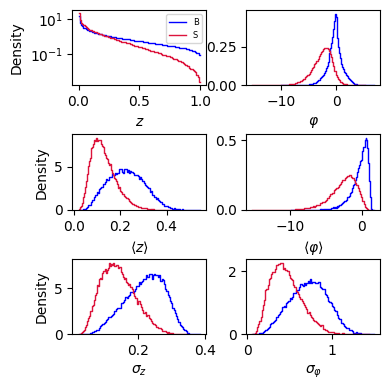

In [10]:
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns


# toy_qcd = np.load('synthetic_data/toy_bkg_data_2M.npy')
# toy_tops = np.load('synthetic_data/toy_sig_data_2M.npy')

qcd_x = toy_qcd[:, :, 0].flatten()
qcd_y = toy_qcd[:, :, 1].flatten()
tops_x = toy_tops[:, :, 0].flatten()
tops_y = toy_tops[:, :, 1].flatten()

qcd_x_mean = toy_qcd[:, :, 0].mean(axis=1)
qcd_y_mean = toy_qcd[:, :, 1].mean(axis=1)
tops_x_mean = toy_tops[:, :, 0].mean(axis=1)
tops_y_mean = toy_tops[:, :, 1].mean(axis=1)

qcd_x_std = toy_qcd[:, :, 0].std(axis=1)
qcd_y_std = toy_qcd[:, :, 1].std(axis=1)
tops_x_std = toy_tops[:, :, 0].std(axis=1)
tops_y_std = toy_tops[:, :, 1].std(axis=1)


# --- Create subplots ---
fig, ax = plt.subplots(3, 2, figsize=(4, 4))

# bins=np.linspace(0,1,40)
bins=100
# --- Plot the histograms ---

# Top row: x and y distributions of z and phi.
sns.histplot(qcd_x, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[0, 0])
sns.histplot(tops_x, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[0, 0])

ax[0,0].set_ylabel('Density')
ax[0,0].set_xlabel(r'$z$')
ax[0,0].set_yscale('log')
ax[0,0].legend(loc='upper right', fontsize=6)


sns.histplot(qcd_y, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[0, 1])
sns.histplot(tops_y, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[0, 1])
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel(r'$\varphi$')

bins=100

# Middle row: mean distributions
sns.histplot(qcd_x_mean, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[1, 0])
sns.histplot(tops_x_mean, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 0])
ax[1,0].set_ylabel('Density')
ax[1,0].set_xlabel(r'$\langle z\rangle$')

sns.histplot(qcd_y_mean, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[1, 1])
sns.histplot(tops_y_mean, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 1])
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel(r'$\langle\varphi\rangle$')

# Bottom row: standard deviation distributions
sns.histplot(qcd_x_std, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[2, 0])
sns.histplot(tops_x_std, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 0])
ax[2,0].set_ylabel('Density')
ax[2,0].set_xlabel(r'$\sigma_z$')

sns.histplot(qcd_y_std, bins=bins, fill=False, color='blue', lw=1, label='B', element='step', stat='density', ax=ax[2, 1])
sns.histplot(tops_y_std, bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 1])
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel(r'$\sigma_\varphi$')

custom_ticks = {
    0: [0, 0.2, 0.4, 0.6, 0.8, 1],
    1: [-8, -4, 0, 4, 8],
    2: [0, 0.1, 0.2, 0.3, 0.4, 0.5] ,
    3: [-8, -4, 0, 4, 8],
    4: [0, 0.1, 0.2, 0.3, 0.4],
    5: [0, 1, 2, 3, 4, 5, 6]
}

plt.tight_layout()
fig.subplots_adjust(hspace=0.65, wspace=0.3) 
plt.savefig('synthetic_jets.png', dpi=300, bbox_inches='tight')
plt.show()


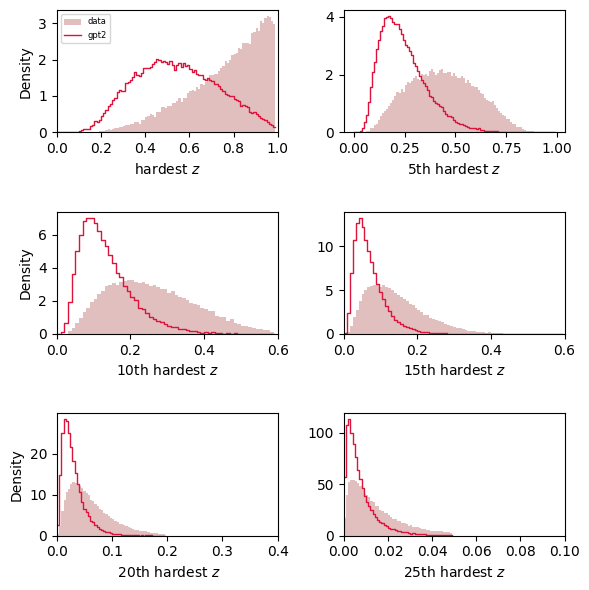

In [24]:
from utils import ordered_z_plots

def canonical_order(samples):
    idx = np.argsort(-samples[:, :, 0], axis=1)
    return np.take_along_axis(samples, idx[:, :, None], axis=1)


toy_qcd_ord = canonical_order(toy_qcd)
toy_tops_ord = canonical_order(toy_tops)

ordered_z_plots(toy_qcd_ord, toy_tops_ord)

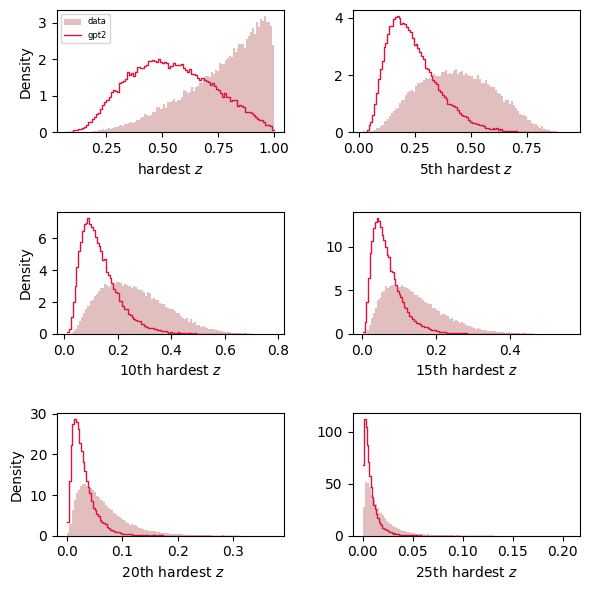

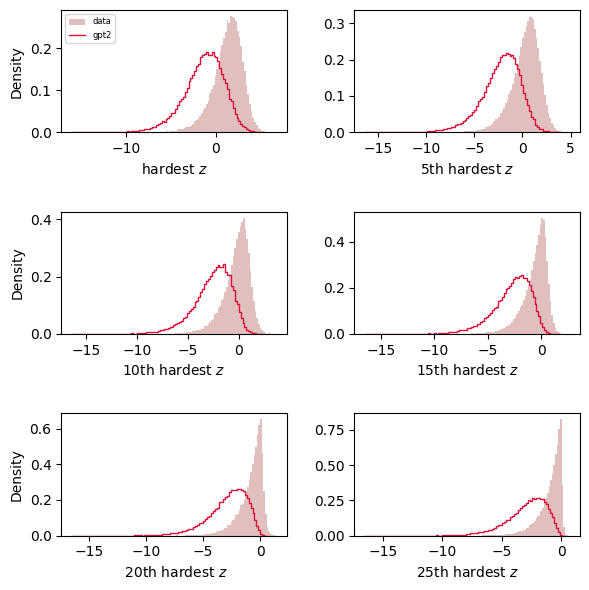

In [25]:

def ordered_z_plots(toy_qcd, gen_jets, save_file='ordered_z_plots.png', feat=0):

    fig, ax = plt.subplots(3, 2, figsize=(6, 6))

    bins=100

    # --- Plot hardest ---

    sns.histplot(toy_qcd[:,0,:][...,feat], bins=bins, alpha=0.25, color='darkred', lw=0, label='data', element='step', stat='density', ax=ax[0, 0])
    sns.histplot(gen_jets[:,0,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='gpt2', element='step', stat='density', ax=ax[0, 0])

    ax[0,0].set_ylabel('Density')
    ax[0,0].set_xlabel(r'hardest $z$')
    ax[0,0].legend(loc='upper left', fontsize=6)
    # ax[0,0].set_xlim(0, 1)


    sns.histplot(toy_qcd[:,5,:][...,feat], bins=bins,   alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[0, 1])
    sns.histplot(gen_jets[:,5,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='gpt2', element='step', stat='density', ax=ax[0, 1])
    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel(r'5th hardest $z$')


    # bins=np.arange(0, 0.6, 0.01)

    sns.histplot(toy_qcd[:,10,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[1, 0])
    sns.histplot(gen_jets[:,10,:][...,feat], bins=bins,  fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 0])

    ax[1,0].set_ylabel('Density')
    ax[1,0].set_xlabel(r'10th hardest $z$')
    # ax[1,0].legend(loc='upper right', fontsize=6)
    # ax[1,0].set_xlim(0, 0.6)

    # bins=np.arange(0, 0.6, 0.008)

    sns.histplot(toy_qcd[:,15,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[1, 1])
    sns.histplot(gen_jets[:,15,:][...,feat], bins=bins, fill=False, color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[1, 1])
    ax[1,1].set_ylabel('')
    ax[1,1].set_xlabel(r'15th hardest $z$')
    # ax[1,1].legend(loc='upper right', fontsize=6)
    # ax[1,1].set_xlim(0, 0.6)


    # Middle row: intermediate distributions

    # bins=np.arange(0, 0.2, 0.004)

    sns.histplot(toy_qcd[:,20,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[2, 0])
    sns.histplot(gen_jets[:,20,:][...,feat], bins=bins, fill=False,  color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 0])

    ax[2,0].set_ylabel('Density')
    ax[2,0].set_xlabel(r' 20th hardest $z$')
    # ax[2,0].legend(loc='upper right', fontsize=6)
    # ax[2,0].set_xlim(0, 0.4)


    # bins=np.arange(0, 0.05, 0.001)

    sns.histplot(toy_qcd[:,25,:][...,feat], bins=bins,  alpha=0.25, color='darkred', lw=0, label='B', element='step', stat='density', ax=ax[2, 1])
    sns.histplot(gen_jets[:,25,:][...,feat], bins=bins, fill=False,  color='crimson', lw=1, label='S', element='step', stat='density', ax=ax[2, 1])
    ax[2,1].set_ylabel('')
    ax[2,1].set_xlabel(r'25th hardest $z$')
    # ax[2,1].legend(loc='upper right', fontsize=6)
    # ax[2,1].set_xlim(0, 0.1)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.65, wspace=0.3) 
    plt.savefig(save_file, dpi=300, bbox_inches='tight')

    plt.show()
    
ordered_z_plots(toy_qcd_ord, toy_tops_ord, feat=0)
ordered_z_plots(toy_qcd_ord, toy_tops_ord, feat=1)

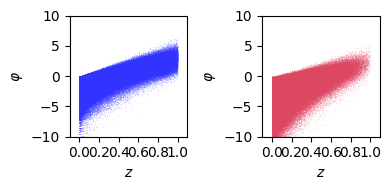

In [11]:
# plot scatterplot of first vs second feature
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
sns.scatterplot(x=qcd_x, y=qcd_y, color='blue', alpha=0.1, s=0.5, ax=ax[0])
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\varphi$')
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_ylim(-10, 10)
ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[0].set_yticks([-10, -5, 0, 5, 10])

sns.scatterplot(x=tops_x, y=tops_y, color='crimson', alpha=0.1, s=0.5, ax=ax[1])
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$\varphi$')
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(-10, 10)
ax[1].set_yscale('linear')
ax[1].set_xscale('linear')
ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[1].set_yticks([-10, -5, 0, 5, 10])

plt.tight_layout()
plt.show()



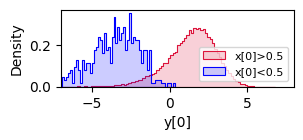

In [30]:
hardest = toy_qcd_ord[:,0]
hardest[hardest[...,0] > 0.5][...,1]

plt.figure(figsize=(3,1.))
sns.histplot(hardest[hardest[...,0] > 0.3][...,1], bins=100, color='crimson', alpha=0.2, lw=0.8, label='x[0]>0.5', element='step', stat='density')
sns.histplot(hardest[hardest[...,0] <= 0.3][...,1], bins=100, color='blue', alpha=0.2, lw=0.8, label='x[0]<0.5', element='step', stat='density')
plt.xlabel(r'y[0]')
plt.xlim(-7, 8)
plt.ylabel('Density')
# plt.yscale('log')
plt.legend(loc='lower right', fontsize=8)
# plt.savefig('toy_LLR.png', dpi=300, bbox_inches='tight')
plt.show()

# Log likleihood computation

In [13]:
logp_tops_on_ss

array([-inf, -inf, -inf, ..., -inf, -inf, -inf])

/tmp/ipykernel_2316056/1291042317.py:128: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = quad(integrand, 0, np.inf, limit=200)
/tmp/ipykernel_2316056/1291042317.py:128: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, err = quad(integrand, 0, np.inf, limit=200)
/tmp/ipykernel_2316056/1291042317.py:128: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the

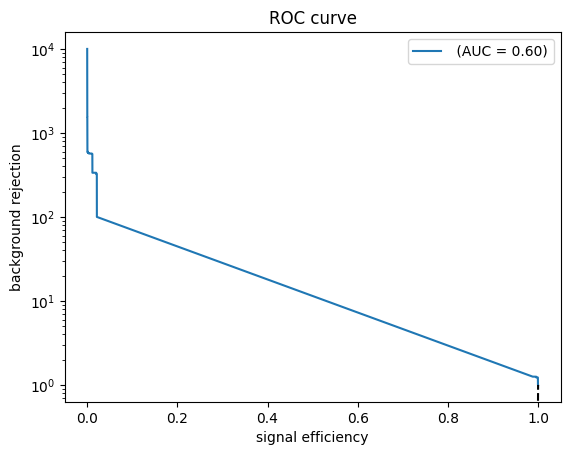

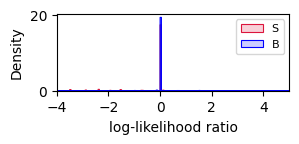

In [12]:
logp_qcd_on_qcd = qcd.log_probs(toy_qcd)
logp_tops_on_tops = tops.log_probs(toy_tops)
logp_qcd_on_tops = qcd.log_probs(toy_tops)
logp_tops_on_qcd = tops.log_probs(toy_qcd)

LLR_qcd = logp_tops_on_qcd - logp_qcd_on_qcd
LLR_tops = logp_qcd_on_tops - logp_tops_on_tops

from utils import ROC
LLR_tops_ = np.nan_to_num(LLR_tops, 0)
LLR_qcd_ = np.nan_to_num(LLR_qcd, 0)

ROC(LLR_qcd, LLR_tops, label='')



plt.figure(figsize=(3,1.))
sns.histplot(LLR_qcd, bins=np.arange(-4,10,0.05), color='crimson', alpha=0.2, lw=0.8, label='S', element='step', stat='density')
sns.histplot(LLR_tops, bins=np.arange(-4,10,0.05), color='blue', alpha=0.2, lw=0.8, label='B', element='step', stat='density')
plt.xlabel(r'log-likelihood ratio')
plt.xlim(-4, 5)
plt.ylabel('Density')
# plt.yscale('log')
plt.legend(loc='upper right', fontsize=8)
# plt.savefig('toy_LLR.png', dpi=300, bbox_inches='tight')
plt.show()